In [7]:
import os
import collections
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 120)

# Use the folder where this notebook lives (UCI HAR DATASET)
DATA_DIR = os.getcwd()
print("DATA_DIR:", DATA_DIR)
print("Files here:", os.listdir(DATA_DIR))


DATA_DIR: c:\Users\tsohail\Downloads\UCI HAR Dataset
Files here: ['.DS_Store', 'activity_labels.txt', 'code.ipynb', 'features.txt', 'features_info.txt', 'README.txt', 'test', 'train']


In [9]:
# ============================
# 2. Load Data & Standardize
# ============================

# 1) Load feature names
features = pd.read_csv(
    os.path.join(DATA_DIR, "features.txt"),
    sep=r"\s+",
    header=None,
    names=["index", "feature_name"]
)
feature_names = features["feature_name"].values

# 2) Make duplicate feature names unique
name_counts = collections.Counter()
new_feature_names = []

for name in feature_names:
    if name_counts[name] == 0:
        new_feature_names.append(name)
    else:
        new_feature_names.append(f"{name}.{name_counts[name]}")
    name_counts[name] += 1

feature_names = new_feature_names

# 3) Activity labels
activity_labels = pd.read_csv(
    os.path.join(DATA_DIR, "activity_labels.txt"),
    sep=r"\s+",
    header=None,
    names=["id", "activity"]
)
activity_mapping = dict(zip(activity_labels["id"], activity_labels["activity"]))

# 4) Train data
X_train = pd.read_csv(
    os.path.join(DATA_DIR, "train", "X_train.txt"),
    sep=r"\s+",
    header=None,
    names=feature_names
)
y_train = pd.read_csv(
    os.path.join(DATA_DIR, "train", "y_train.txt"),
    sep=r"\s+",
    header=None,
    names=["activity_id"]
)

# 5) Test data
X_test = pd.read_csv(
    os.path.join(DATA_DIR, "test", "X_test.txt"),
    sep=r"\s+",
    header=None,
    names=feature_names
)
y_test = pd.read_csv(
    os.path.join(DATA_DIR, "test", "y_test.txt"),
    sep=r"\s+",
    header=None,
    names=["activity_id"]
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# 6) Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Standardization complete.")


X_train shape: (7352, 561)
X_test shape: (2947, 561)
y_train shape: (7352, 1)
y_test shape: (2947, 1)
Standardization complete.


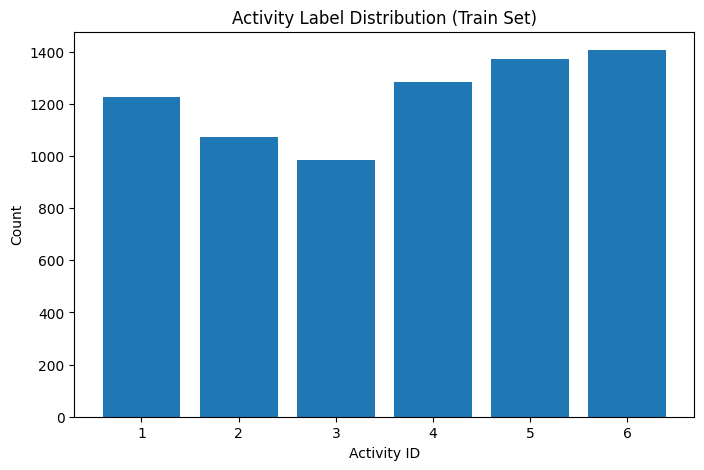

Activity mapping:
   id            activity
0   1             WALKING
1   2    WALKING_UPSTAIRS
2   3  WALKING_DOWNSTAIRS
3   4             SITTING
4   5            STANDING
5   6              LAYING


In [10]:
# Activity label distribution (histogram)
label_counts = y_train["activity_id"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
plt.bar(label_counts.index.astype(str), label_counts.values)
plt.title("Activity Label Distribution (Train Set)")
plt.xlabel("Activity ID")
plt.ylabel("Count")
plt.show()

print("Activity mapping:")
print(activity_labels)


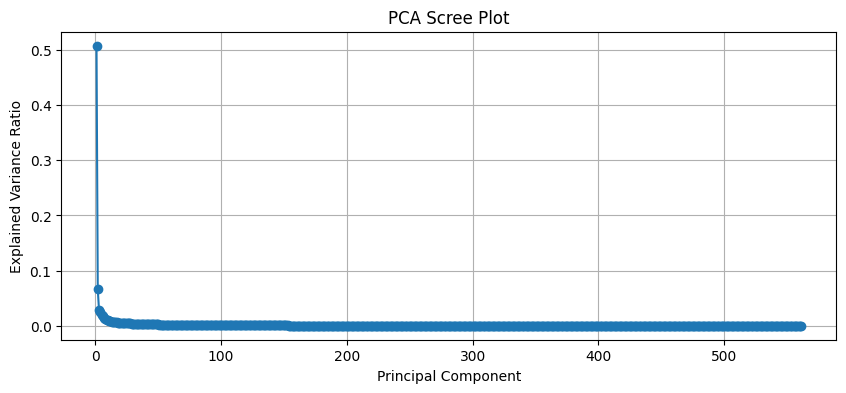

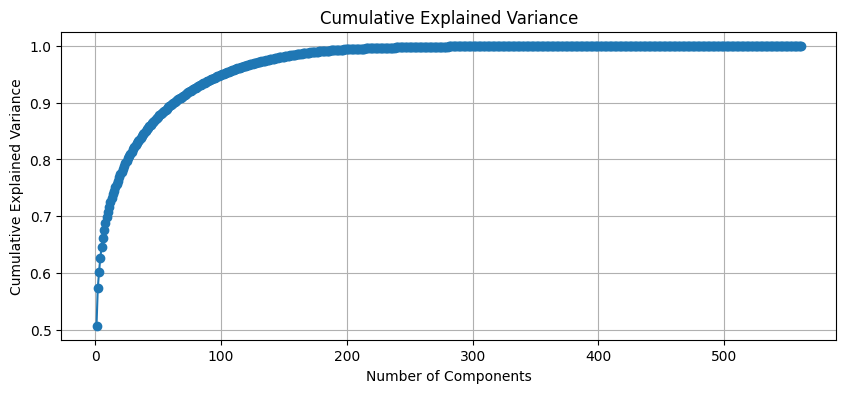

Using k_pca = 60


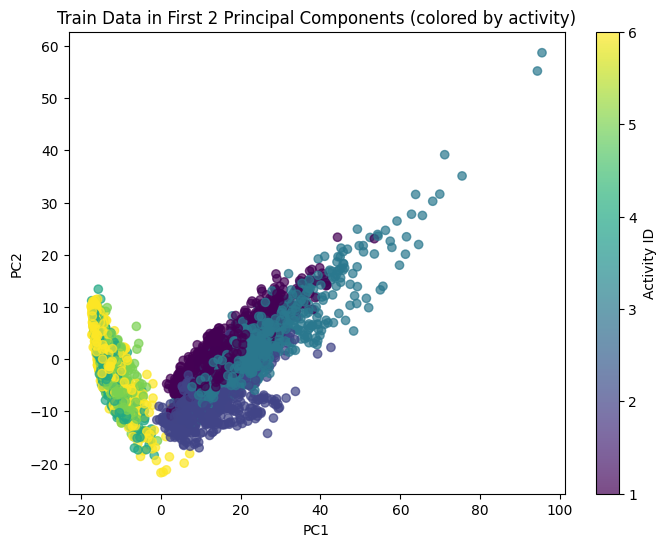

In [11]:
# ============================
# 4. PCA Analysis
# ============================

# Fit PCA on standardized training data
pca = PCA()
pca.fit(X_train_scaled)

explained_var = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained_var)

# 4.1 Scree plot (individual explained variance)
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Scree Plot")
plt.grid(True)
plt.show()

# 4.2 Cumulative explained variance
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(cum_explained) + 1), cum_explained, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance")
plt.grid(True)
plt.show()

# Choose k after looking at the plots (you can change this)
k_pca = 60
print("Using k_pca =", k_pca)

# 4.3 First two PCs for visualization
pca_2 = PCA(n_components=2)
X_train_pca2 = pca_2.fit_transform(X_train_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_train_pca2[:, 0],
    X_train_pca2[:, 1],
    c=y_train["activity_id"],
    alpha=0.7
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Train Data in First 2 Principal Components (colored by activity)")
plt.colorbar(scatter, label="Activity ID")
plt.show()


k = 2, silhouette = 0.3965
k = 3, silhouette = 0.3274
k = 4, silhouette = 0.1613
k = 5, silhouette = 0.1306
k = 6, silhouette = 0.1086
k = 7, silhouette = 0.1114
k = 8, silhouette = 0.0896
k = 9, silhouette = 0.0838
k = 10, silhouette = 0.0822

Best k = 2


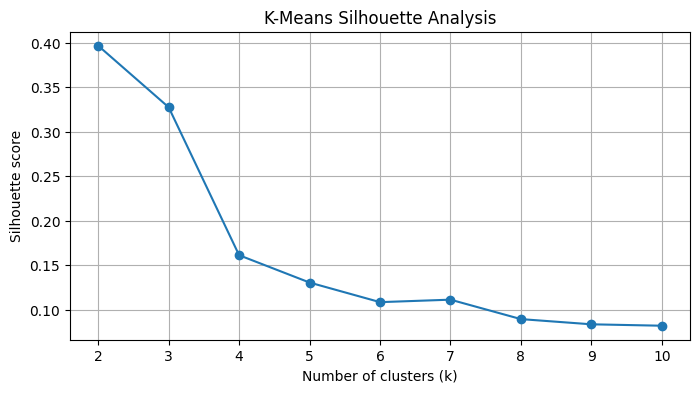

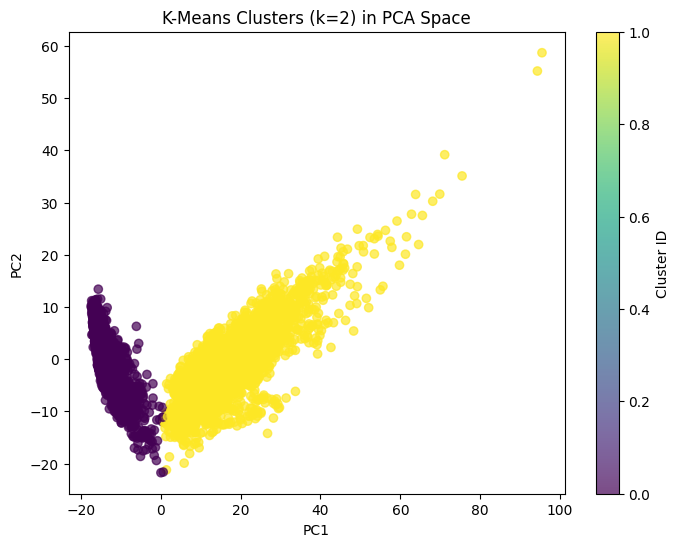

In [12]:
# ============================
# 5. K-Means Clustering
# ============================

range_n_clusters = range(2, 11)
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
    cluster_labels = kmeans.fit_predict(X_train_scaled)
    score = silhouette_score(X_train_scaled, cluster_labels)
    silhouette_scores.append(score)
    print(f"k = {n_clusters}, silhouette = {score:.4f}")

# Best k based on silhouette
best_k = range_n_clusters[int(np.argmax(silhouette_scores))]
print("\nBest k =", best_k)

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(list(range_n_clusters), silhouette_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("K-Means Silhouette Analysis")
plt.grid(True)
plt.show()
# Visualize best K-Means clusters in PCA 2D space
best_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
kmeans_labels = best_kmeans.fit_predict(X_train_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_train_pca2[:, 0],
    X_train_pca2[:, 1],
    c=kmeans_labels,
    alpha=0.7
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"K-Means Clusters (k={best_k}) in PCA Space")
plt.colorbar(scatter, label="Cluster ID")
plt.show()


DBSCAN labels found: {np.int64(-1)}
Number of clusters (excluding noise): 0
Noise points: 7352
Not enough clusters for silhouette score.


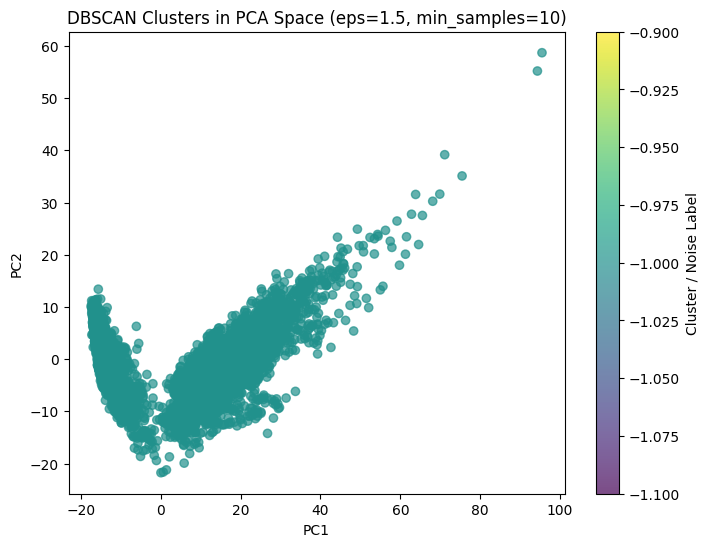

In [13]:
# ============================
# 6. DBSCAN Clustering
# ============================

# You can tune these two values
eps_value = 1.5
min_samples_value = 10

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
dbscan_labels = dbscan.fit_predict(X_train_scaled)

unique_labels = set(dbscan_labels)
n_clusters_dbscan = len([l for l in unique_labels if l != -1])

print("DBSCAN labels found:", unique_labels)
print("Number of clusters (excluding noise):", n_clusters_dbscan)
print("Noise points:", np.sum(dbscan_labels == -1))

# Calculate silhouette score (only if we have 2+ clusters)
mask = dbscan_labels != -1

if len(set(dbscan_labels[mask])) > 1:
    score_dbscan = silhouette_score(X_train_scaled[mask], dbscan_labels[mask])
    print("Silhouette score (excluding noise):", score_dbscan)
else:
    print("Not enough clusters for silhouette score.")
    plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_train_pca2[:, 0],
    X_train_pca2[:, 1],
    c=dbscan_labels,
    alpha=0.7
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"DBSCAN Clusters in PCA Space (eps={eps_value}, min_samples={min_samples_value})")
plt.colorbar(scatter, label="Cluster / Noise Label")
plt.show()



In [14]:
# ============================
# 7. Feature Selection
# ============================

# 7.1 PCA-based reduced feature set (using k_pca from earlier)
pca_k = PCA(n_components=k_pca)
X_train_pca_k = pca_k.fit_transform(X_train_scaled)
X_test_pca_k = pca_k.transform(X_test_scaled)

print("PCA-reduced train shape:", X_train_pca_k.shape)
print("PCA-reduced test shape:", X_test_pca_k.shape)


PCA-reduced train shape: (7352, 60)
PCA-reduced test shape: (2947, 60)


In [15]:
# 7.2 Random Forest-based feature selection

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_scaled, y_train.values.ravel())
importances = rf.feature_importances_
indices_sorted = np.argsort(importances)[::-1]

# Top k original features
top_k_indices = indices_sorted[:k_pca]
top_k_features = [feature_names[i] for i in top_k_indices]

print("Number of RF-selected features:", len(top_k_features))
print("First 10 RF-selected features:")
print(top_k_features[:10])

# Build reduced datasets using only those features
X_train_rf_k = X_train_scaled[:, top_k_indices]
X_test_rf_k = X_test_scaled[:, top_k_indices]

print("RF-selected train shape:", X_train_rf_k.shape)
print("RF-selected test shape:", X_test_rf_k.shape)


Number of RF-selected features: 60
First 10 RF-selected features:
['tGravityAcc-mean()-X', 'tGravityAcc-min()-X', 'tGravityAcc-mean()-Y', 'angle(X,gravityMean)', 'tGravityAcc-energy()-X', 'angle(Y,gravityMean)', 'tGravityAcc-min()-Y', 'tGravityAcc-max()-X', 'tGravityAcc-max()-Y', 'tGravityAcc-energy()-Y']
RF-selected train shape: (7352, 60)
RF-selected test shape: (2947, 60)


In [16]:
# ============================
# 8. Classification – Logistic Regression
# ============================

def train_and_evaluate(X_tr, X_te, y_tr, y_te, desc=""):
    print("\n==============================")
    print(desc)
    print("==============================")
    model = LogisticRegression(
        max_iter=1000,
        multi_class="multinomial",
        n_jobs=-1
    )
    model.fit(X_tr, y_tr.values.ravel())
    y_pred = model.predict(X_te)
    print(classification_report(y_te, y_pred, digits=4))
    return model


In [17]:
baseline_model = train_and_evaluate(
    X_train_scaled, X_test_scaled,
    y_train, y_test,
    "Logistic Regression – FULL 561 features"
)



Logistic Regression – FULL 561 features


C:\Users\tsohail\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1     0.9426    0.9940    0.9676       496
           2     0.9550    0.9469    0.9510       471
           3     0.9899    0.9357    0.9621       420
           4     0.9685    0.8758    0.9198       491
           5     0.8900    0.9737    0.9300       532
           6     0.9981    0.9926    0.9953       537

    accuracy                         0.9545      2947
   macro avg     0.9574    0.9531    0.9543      2947
weighted avg     0.9563    0.9545    0.9544      2947



In [ ]:
pca_model = train_and_evaluate(
    X_train_pca_k, X_test_pca_k,
    y_train, y_test,
    f"Logistic Regression – top {k_pca} PCA components"
)


In [18]:
rf_model = train_and_evaluate(
    X_train_rf_k, X_test_rf_k,
    y_train, y_test,
    f"Logistic Regression – top {k_pca} RF-selected features"
)



Logistic Regression – top 60 RF-selected features


C:\Users\tsohail\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1     0.9006    0.9859    0.9413       496
           2     0.8778    0.9002    0.8889       471
           3     0.9755    0.8548    0.9112       420
           4     0.8264    0.7271    0.7736       491
           5     0.7768    0.8571    0.8150       532
           6     0.9981    0.9926    0.9953       537

    accuracy                         0.8884      2947
   macro avg     0.8925    0.8863    0.8875      2947
weighted avg     0.8907    0.8884    0.8877      2947

